In [1]:
#Importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.applications.mobilenet import MobileNet,preprocess_input
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array



/home/krishna/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-01-06 12:10:21.179209: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 12:10:21.179261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 12:10:21.180273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been 

In [2]:
#Build our model
model = MobileNet(input_shape=(224,224,3),include_top=False)

for layer in model.layers:
    layer.trainable=False # We don't want to train the model again or use the weights of the model
x = Flatten()(model.output)  # Convert the 3D output to 1D so that we can add our own output layer
x = Dense(7,activation='softmax')(x) # Add our own output layer with 7 neurons as we have 7 classes

model = Model(model.input,x) # Create the model

model.summary()  #Print the summary of the model

2024-01-06 12:10:23.436972: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-06 12:10:23.473010: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-06 12:10:23.473299: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [3]:
#Compile the model
# Because we have added our own output layer and we need to train the model again
# So we need to compile the model again
model.compile(optimizer='adam',loss=categorical_crossentropy,metrics=['accuracy'])

In [5]:
#Load the dataset
# Because we have a large dataset and we can't load all the images at once
# So we use data generator to load the images in batches

train_datagen = ImageDataGenerator(
                zoom_range=0.2, # We can zoom the image upto 20%
                shear_range=0.2, # We can shear the image upto 20%
                                 #which means that we can tilt the image upto 20%
                horizontal_flip=True, # We can flip the image horizontally
                rescale=1./255, # Rescale the image by dividing all the pixel values by 255
)

train_data = train_datagen.flow_from_directory(
             directory='train', # Path of the training dataset
             target_size=(224,224), # Size of the image
             batch_size=32, # Batch size is the number of images that we want to load at once because we can't load all the images at once
)

print(train_data.class_indices) # Print the class indices
#The class indices are the labels of the classes


Found 29059 images belonging to 14 classes.
{'Angry': 0, 'Disguist': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6, 'angry': 7, 'disgust': 8, 'fear': 9, 'happy': 10, 'neutral': 11, 'sad': 12, 'surprise': 13}


In [6]:
# validate the dataset
#  Because we need to check whether our model is overfitting or not

val_datagen = ImageDataGenerator(rescale=1./255)

val_data = val_datagen.flow_from_directory(
             directory='test', # Path of the training dataset
             target_size=(224,224), # Size of the image
             batch_size=32, # Batch size is the number of images that we want to load at once because we can't load all the images at once

             )


Found 7178 images belonging to 7 classes.


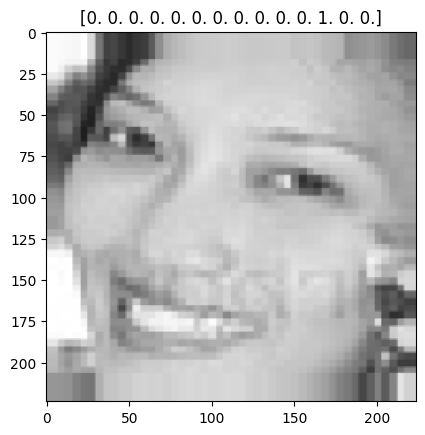

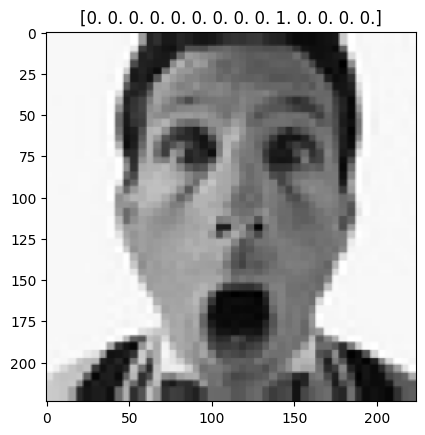

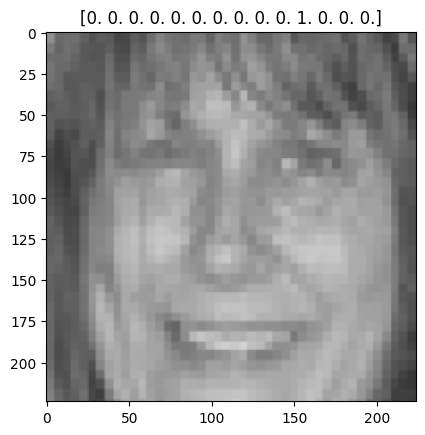

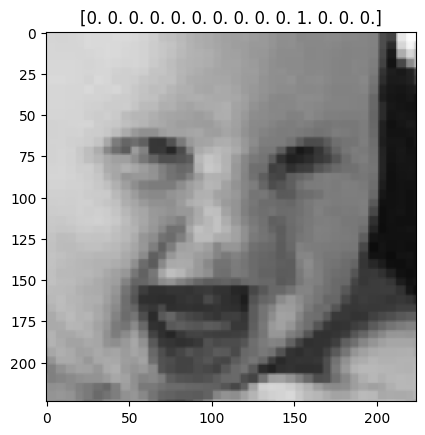

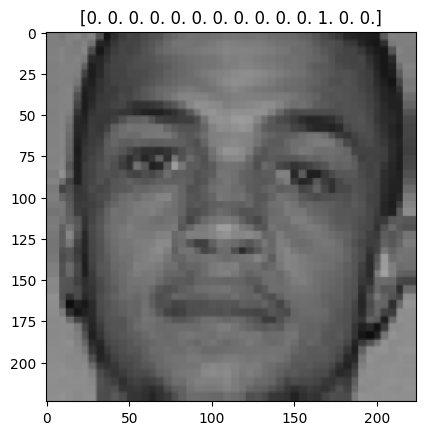

In [7]:
# visualize the dataset
#  Because we need to check whether our model is overfitting or not

target_image , label = train_data.next() # Load the images and labels in the target_image and label variables
def plot_images (image_arr,label):
    count = 0
    for image,label in zip(image_arr,label):
        plt.imshow(image)
        plt.title(label)
        plt.show()
        count+=1
        if count==5:
            break
plot_images(target_image,label)

In [9]:
# Early Stopping and Model Checkpoint
# Early Stopping is used to stop the training of the model if the model is not learning
# Model Checkpoint is used to save the model with the best accuracy

from keras.callbacks import EarlyStopping,ModelCheckpoint

earlystop = EarlyStopping(monitor='val_accuracy',patience=5,verbose=1,mode='auto',min_delta=0.01)
# monitor is the parameter that we want to monitor
# patience is the number of epochs that we want to wait for the model to learn
# verbose is the information that we want to print
# verbose=0 means that we don't want to print the information
# verbose=1 A progress bar will be displayed in the console, showing the completion of each epoch, along with additional information like loss and accuracy.
#verbose = 2 you will see one line of training information per epoch. It provides a summary of the training process after each epoch.
#mode is the direction of the learning min or max or auto
# min means that we want to minimize the parameter
# max means that we want to maximize the parameter
# auto means that it will automatically decide the direction of the learning
# min_delta is the minimum change in the parameter that we want to monitor to be considered as an improvement


bestcheck = ModelCheckpoint('best_model.h5',monitor='val_accuracy',verbose=1,save_best_only=True,mode='auto')


In [10]:
hist = model.fit_generator(
       train_data, # Training data
       epochs=30, # Number of epochs that we want to train the model
       steps_per_epoch=10,# steps_per_epoch is the number of batches that we want to train in one epoch
       validation_data=val_data, # Validation data
       validation_steps=8, # Number of batches that we want to validate in one epoch
       callbacks=[earlystop,bestcheck] # Callbacks
)



/tmp/ipykernel_26080/3022796695.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/30


2024-01-06 12:11:05.383042: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 65.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-06 12:11:05.383079: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-01-06 12:11:05.411531: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-06 12:11:05.614165: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 57.34MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if mor

ResourceExhaustedError: Graph execution error:

Detected at node model/conv_pw_1/Conv2D defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/krishna/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/krishna/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/krishna/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/krishna/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/krishna/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/krishna/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/krishna/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/krishna/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/krishna/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/krishna/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/krishna/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/krishna/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/krishna/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/krishna/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/krishna/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/krishna/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_26080/3022796695.py", line 1, in <module>

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2916, in fit_generator

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1810, in fit

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1404, in train_function

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1387, in step_function

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1376, in run_step

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1153, in train_step

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 593, in __call__

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/home/krishna/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

OOM when allocating tensor with shape[32,64,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv_pw_1/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_4247]

In [ ]:
#loading the best fit model
from keras.models import load_model
model = load_model('/content/best_model.h5')

In [ ]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

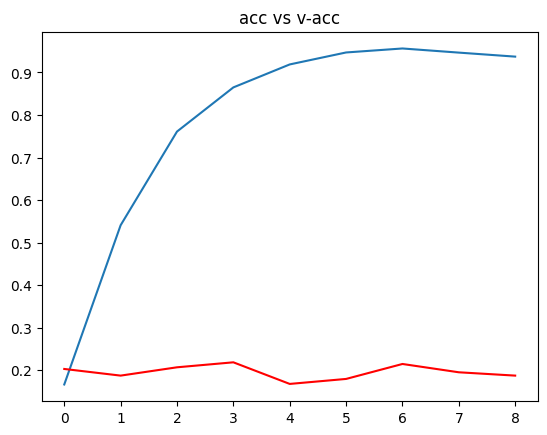

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c='red')
plt.title("acc vs v-acc")
plt.show()

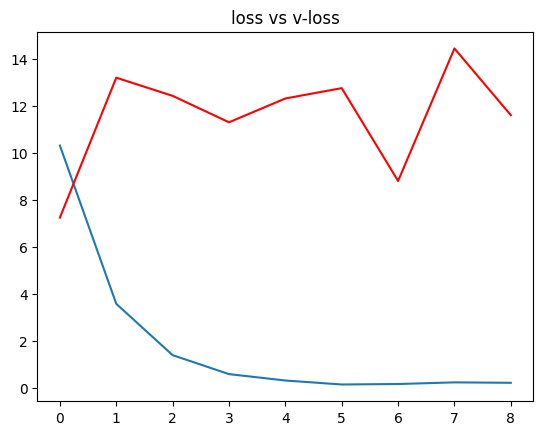

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c='red')
plt.title("loss vs v-loss")
plt.show()

In [ ]:
# just map o/p values
op = dict(zip(train_data.class_indices.values(), train_data.class_indices.keys()))

In [ ]:
#test it

path = "/content/drive/MyDrive/image.jpg"
image = load_img(path,target_size=(224,224))

img2arr = img_to_array(image)/255
input_arr = np.array(img2arr)
input_arr.shape

(224, 224, 3)

1/1 [==============================] - 1s 1s/step
label of the image is Happy


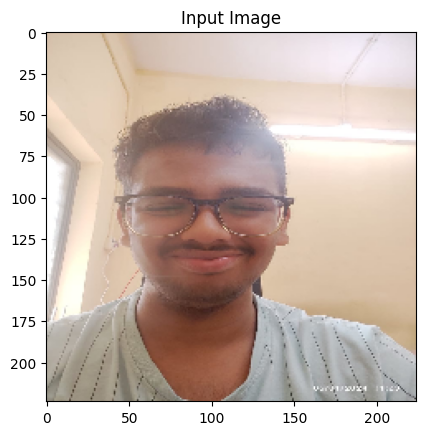

In [ ]:
input_arr = np.expand_dims(input_arr, axis=0)
pred = np.argmax(model.predict(input_arr))
print(f"label of the image is {op[pred]}")

plt.imshow(input_arr[0])
plt.title("Input Image")
plt.show()
